# Exercise 7.2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [2]:
class RandomWalkEnv:
	def __init__(self, num_states=5):
		self.states = np.arange(1, num_states + 1)  # Non-terminal states
		self.start_state = num_states // 2
		self.terminal_rewards = {0: 0, num_states + 1: 1}
	
	def reset(self):
		self.current_state = self.start_state
		return self.current_state

	def step(self):
		# Move randomly left or right
		self.current_state += np.random.choice([-1, 1])
		if self.current_state in self.terminal_rewards:
			reward = self.terminal_rewards[self.current_state]
			done = True
		else:
			reward = 0
			done = False
		return self.current_state, reward, done

In [3]:
def td_n_step(env, n, alpha, gamma, method="n_step", episodes=500):
	value_estimates = np.zeros(env.states.size + 2)  # +2 for terminal states
	mse_per_episode = []
	deltas = []

	for episode in range(episodes):
		state = env.reset()
		states, rewards = [state], [0] # we won't use the first reward, but it's easier to keep the indices aligned
		T = float('inf')
		t = 0

		while True:
			if t < T:
				next_state, reward, done = env.step()
				states.append(next_state)
				rewards.append(reward)
				if done:
					T = t + 1
				deltas.append(rewards[t + 1] + gamma * value_estimates[states[t + 1]] - value_estimates[states[t]])
			tau = t - n + 1
			if tau >= 0:
				G = 0
				if method == "n_step":
					# Calculate the n-step return
					for i in range(tau + 1, min(tau + n, T) + 1):
						G += (gamma ** (i - tau - 1)) * rewards[i]
					if tau + n < T:
						G += (gamma ** n) * value_estimates[states[tau + n]]
					td_error = G - value_estimates[states[tau]]
				
				elif method == "sum_td_errors":
					# Calculate the sum of TD errors
					td_error = 0
					for k in range(min(n, T - tau)):
						td_error += (gamma ** k) * deltas[tau + k]
				
				# Update value estimate
				value_estimates[states[tau]] += alpha * td_error

			t += 1
			if tau == T - 1:
				break
		
		# Measure MSE against a known or pre-computed true value function
		true_values = np.linspace(0, 1, env.states.size + 2)  # Example true values for illustration
		mse = np.mean((value_estimates[1:env.states.size + 1] - true_values[1:env.states.size + 1]) ** 2)
		mse_per_episode.append(mse)
	return mse_per_episode

In [4]:
def calculate_rms_error_and_variance(number_of_states, n, alpha, gamma, method="n_step", episodes=10, runs=100):
	env = RandomWalkEnv(number_of_states)
	mse_per_episode = []
	for _ in range(runs):
		mse_per_episode.append(td_n_step(env, n, alpha, gamma, method, episodes)[-1])
	return np.mean(mse_per_episode), np.var(mse_per_episode)

alpha_values = np.linspace(0, 0.5, 20)  
n_values = [2, 4, 8] 
methods = ["n_step", "sum_td_errors"]

mse = {(n, method): [] for n, method in product(n_values, methods)}
var = {(n, method): [] for n, method in product(n_values, methods)}

# Loop through combinations of alpha and n
for alpha, n, method in product(alpha_values, n_values, methods):
    # Calculate RMS error for each combination
    rms_error = calculate_rms_error_and_variance(5, n, alpha, 1, method=method, episodes=10, runs=1000)
    # Append the result for each (n, method) combination
    mse[(n, method)].append(rms_error[0])
    var[(n, method)].append(rms_error[1])


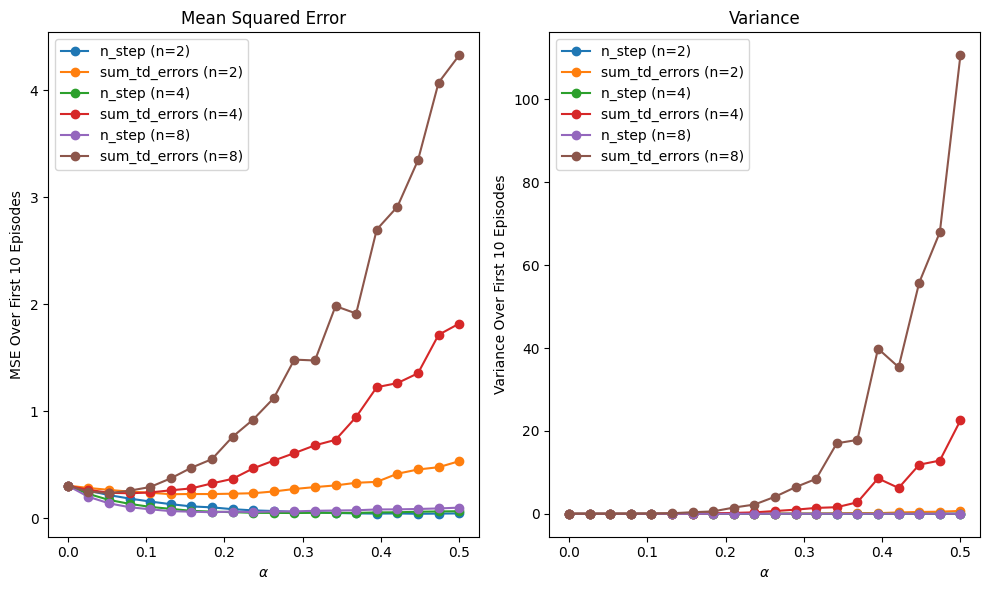

In [6]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
for (n, method), mse_values in mse.items():
    plt.plot(alpha_values, mse_values, label=f"{method} (n={n})", marker='o')
plt.xlabel(r"$\alpha$")
plt.ylabel("MSE Over First 10 Episodes")
plt.title("Mean Squared Error")
plt.legend()    

# Plot Variance
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
for (n, method), var_values in var.items():
    plt.plot(alpha_values, var_values, label=f"{method} (n={n})", marker='o')
plt.xlabel(r"$\alpha$")
plt.ylabel("Variance Over First 10 Episodes")
plt.title("Variance")
plt.legend()

plt.tight_layout()
plt.savefig("../chapters_latex/figures/ex_07_02.pdf")
plt.show()